In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import subprocess
import time
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
#do change


#this name is being used as identifier in some of the document names, it is also the name of the working directory
foldername_basic = '2016-11-03_2123' 
#working directory
folder = r'/Users/Pat/Documents/Harvard/Interpolation/%s/' %foldername_basic
#next two parameters take path and name of the KML windsond file
folder_kml = folder
name_kml = '%s.kml' %foldername_basic
#name of the origional windsond profile file
folder_ws_profile =folder
name_ws_profile = 'windsond_data_central_park_fremond_2-16-11-03_2123.txt'
#name for the file created in the process of reading the kml file
csv_name_loc = 'ws_path_%s.csv' %foldername_basic #ws = windsond
#name for the file created in the process of converting the original windsonds profile to readable csv
filename_ws = 'ws_profile_%s.txt' %foldername_basic
#name for the file created in the process of selecting grid points around ws path
csv_name_room = 'grid_around_path_%s.csv'%foldername_basic
#the next two parameters take path and name of the "NAM12 Lat/Lon Pair" file
folder_llpair = r'/Users/Pat/Documents/Harvard/'
filename_llpair = r'Nam12_Latitude_Longitude_Pairs.csv'
#path for the NAM12 files
folder_nam12 = '/Users/Pat/Documents/Harvard/Nam12/hysplit/'
#This parameter has tuples in list. First argument of the tuple is NAM12 file name (day), second is time in UTC.
#valid times are  0-23, but the choosen time will be reduced to one of 0,3,6,9,12,15,18,21.
folder_time_pair = [('20161103_nam12',21),('20161104_nam12',0)]
#Path were all profiles moved to. Profiles are created while running this algorithm and are moved to the folder the jupyter notebook is executed at.
folder_profile = folder 


#the delta in altitude determines how often gps info is read for the windsond path in the kml file
delta_kml = 99

#windsond info (data available in the origional windsond profile file)
#Point of time at peak in UTC. Calculated with the windsond textfile start time + time until peak
t_peak = dt.timedelta(hours = 21,minutes = 26, seconds = 36) + dt.timedelta(hours = 1,minutes = 49, seconds = 0) 
#altitude of the peak
alt_peak = 4141 #MSL
#mean rize speed
a_rize = 0.6 #m/s
#ground height in MSL
ground_height = 8

#plot info
#folder for ws profile
folder_ws = folder
#plot PDF file name
pp = PdfPages(folder + 'Comparison_WS_NAM12(interp16pts)_%s.pdf' %foldername_basic) 
plot_title = 'Fremond_Central_Park_%s' %foldername_basic



In [3]:
#read ws path out of kml file with a delta in altitude of "delta_kml"

#do not change
geo_info_list = []
alt_kml = 0

#read in kml
f = open(folder_kml+name_kml,'r')
kml_lines = f.readlines()
f.close()

#fetch geo data every 100m
for line in kml_lines:
    if line[0] == '-':
        split_line = line.split(',')

        if int(split_line[2]) > alt_kml:
            print (split_line[0] + ',' + split_line[1] + ',' + split_line[2])
            geo_info_list.append(split_line[0] + ',' + split_line[1] + ',' + split_line[2])
            alt_kml = int(split_line[2]) + delta_kml


#write data in csv
f= open(folder+csv_name_loc,'w')
f.write('lon,lat,alt\n')
f.writelines(geo_info_list)
f.close()



-121.964008,37.544508,8

-121.965363,37.544328,109

-121.967923,37.543647,215

-121.968847,37.543103,316

-121.969850,37.542845,418

-121.971433,37.541517,522

-121.972080,37.541215,624

-121.971765,37.542085,726

-121.975265,37.545212,826

-121.978568,37.549820,926

-121.981422,37.553705,1027

-121.986878,37.562652,1129

-121.991018,37.570990,1232

-121.992672,37.579662,1333

-121.995350,37.588472,1433

-121.998647,37.593640,1537

-121.997222,37.596627,1638

-121.997163,37.602872,1741

-121.999207,37.608178,1844

-122.001260,37.612463,1946

-122.002648,37.616480,2046

-122.001922,37.621600,2146

-121.997718,37.623088,2246

-121.993768,37.624218,2347

-121.990740,37.626155,2447

-121.988367,37.628630,2548

-121.988112,37.630972,2648

-121.991038,37.633318,2749

-121.992660,37.635188,2849

-121.993732,37.637087,2949

-121.996163,37.639683,3049

-121.999640,37.642662,3149

-122.003772,37.647275,3250

-122.005820,37.650228,3353

-122.007982,37.653983,3453

-122.009688,37.662208,3553

-122

In [4]:
#convert windsond file to readable csv format

#do not change
lines = []


#fetch data
f = open(folder_ws_profile + name_ws_profile,'r')
lines = f.readlines()
f.close()

#find beginning
for n,line in enumerate(lines):
    if line[:4] == ' alt':
        header_line = n

#bring into readable format
lines[header_line] = lines[header_line].replace('wind dir','wind-dir').replace('/',' ').replace('hum','')
lines[header_line+1] = lines[header_line+1].replace('(%)','(\xb0)').replace('m AGL','m-AGL')

for n,line in enumerate(lines[header_line+2:]):
    lines[n+header_line+2] = line.replace('\xb0','').replace('/',' ')

#save
f = open(folder+filename_ws,'w')
f.writelines(lines[header_line:])
f.close()

In [5]:
#Fetch 4 grid points around the windsond path

#do not change
#read in nam12 grid
df = pd.read_csv(folder_llpair+filename_llpair, delim_whitespace = 1)
#read in locations of windsond (delta 100m)
df_loc = pd.read_table(folder+csv_name_loc,sep=',')
#Output Dataframe
df_room = pd.DataFrame(columns = ['x1','y1','x2','y2','x3','y3','x4','y4','d1','d2','d3','d4','lat','lon','alt','time_est'])


lat = df_loc['lat'].tolist()
lon = df_loc['lon'].tolist()
alt = df_loc['alt'].tolist()

for i in range(len(lat)):
    #calculate distance of points
    df['Delta'] = (np.sqrt(np.square((abs(df.LAT - lat[i])) + np.square(abs(df.LON - lon[i])))))
    #x,y
    x,y = df.loc[df['Delta'] == df['Delta'].min().item()].I.item(), df.loc[df['Delta'] == df['Delta'].min().item()].J.item()
    
    #x2,y2
    if abs((df.loc[(df['I'] == x+1) & (df['J'] == y)].LON.item())-lon[i]) < abs((df.loc[(df['I'] == x-1) & (df['J'] == y)].LON.item())-lon[i]):
        x2, y2 = df.loc[(df['I'] == x+1) & (df['J'] == y)].I.item(), df.loc[(df['I'] == x+1) & (df['J'] == y)].J.item()
    else:
        x2, y2 = df.loc[(df['I'] == x-1) & (df['J'] == y)].I.item(), df.loc[(df['I'] == x-1) & (df['J'] == y)].J.item()
        
    #x3.y3
    if abs((df.loc[(df['I'] == x) & (df['J'] == y+1)].LAT.item())-lat[i]) < abs((df.loc[(df['I'] == x) & (df['J'] == y-1)].LAT.item())-lat[i]):
        x3, y3 = df.loc[(df['I'] == x) & (df['J'] == y+1)].I.item(), df.loc[(df['I'] == x) & (df['J'] == y+1)].J.item()
    else:
        x3, y3 = df.loc[(df['I'] == x) & (df['J'] == y-1)].I.item(), df.loc[(df['I'] == x) & (df['J'] == y-1)].J.item()
    
    #x4,y4
    x4,y4 = x2,y3
    
    #d1-d4
    d1 = df.loc[(df['I'] == x) & (df['J'] == y)].Delta.item()
    d2 = df.loc[(df['I'] == x2) & (df['J'] == y2)].Delta.item()
    d3 = df.loc[(df['I'] == x3) & (df['J'] == y3)].Delta.item()
    d4 = df.loc[(df['I'] == x4) & (df['J'] == y4)].Delta.item()
    
    #print x,y,x2,y2,x3,y3,x4,y4
    grid_list = [x,y,x2,y2,x3,y3,x4,y4,d1,d2,d3,d4]
    
    #prepare data for Dataframe
    room = grid_list 
    room.append(lat[i])
    room.append(lon[i])
    room.append(alt[i])
    
    #add time row
    room.append(t_peak - dt.timedelta(seconds = (alt_peak - int(alt[i]))/a_rize))

    #append data to DataFrame
    df_room.loc[len(df_room)] = [room[n] for n in range(16)]


    
#to csv
df_room.to_csv(path_or_buf = folder+csv_name_room, sep = ',',index = False)
df_room


    
    


,x1,y1,x2,y2,x3,y3,x4,y4,d1,d2,d3,d4,lat,lon,alt,time_est
0,150.0,204.0,149.0,204.0,150.0,205.0,149.0,205.0,0.051560,0.052412,0.087003,0.052764,37.544508,-121.964008,8.0,21:20:47.666667
1,150.0,204.0,149.0,204.0,150.0,205.0,149.0,205.0,0.051767,0.052262,0.087499,0.052901,37.544328,-121.965363,109.0,21:23:36
2,149.0,204.0,148.0,204.0,149.0,205.0,148.0,205.0,0.051646,0.086566,0.053511,0.053113,37.543647,-121.967923,215.0,21:26:32.666667
3,149.0,204.0,148.0,204.0,149.0,205.0,148.0,205.0,0.051129,0.085804,0.054033,0.053391,37.543103,-121.968847,316.0,21:29:21
4,149.0,204.0,148.0,204.0,149.0,205.0,148.0,205.0,0.050903,0.085313,0.054268,0.053361,37.542845,-121.969850,418.0,21:32:11
5,149.0,204.0,148.0,204.0,149.0,205.0,148.0,205.0,0.049628,0.083620,0.055565,0.054239,37.541517,-121.971433,522.0,21:35:04.333333
6,149.0,204.0,148.0,204.0,149.0,205.0,148.0,205.0,0.049349,0.083170,0.055856,0.054359,37.541215,-121.972080,624.0,21:37:54.333333
7,149.0,204.0,148.0,204.0,149.0,205.0,148.0,205.0,0.050208,0.084112,0.054991,0.053578,37.542085,-121.971765,726.0,21:40:44.333333
8,148.0,205.0,149.0,205.0,148.0,204.0,149.0,204.0,0.049476,0.051815,0.086452,0.053473,37.545212,-121.975265,826.0,21:43:31
9,148.0,205.0,149.0,205.0,148.0,204.0,149.0,204.0,0.043971,0.047184,0.090340,0.058233,37.549820,-121.978568,926.0,21:46:17.666667


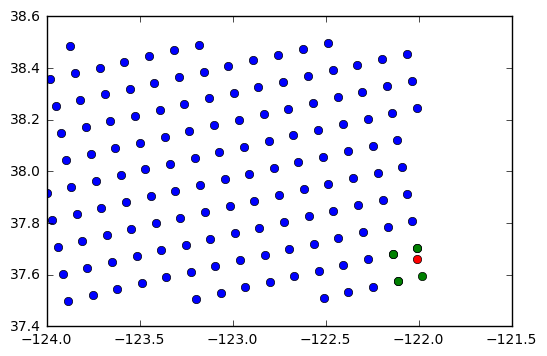

In [6]:
#test grid visually
n = 35

#do not change
df_sanfran = df.loc[(df['LAT'] < 38.50) & (df['LAT'] > 37.50) & (df['LON'] > -124.00) & (df['LON'] < -122.0)]
df_point = df.loc[(df['I'] == df_room.x1[n]) & (df['J'] == df_room.y1[n])]
df_point2 = df.loc[(df['I'] == df_room.x2[n]) & (df['J'] == df_room.y2[n])]
df_point3 = df.loc[(df['I'] == df_room.x3[n]) & (df['J'] == df_room.y3[n])]
df_point4 = df.loc[(df['I'] == df_room.x4[n]) & (df['J'] == df_room.y4[n])]

plt.clf()
plt.plot(df_sanfran.LON, df_sanfran.LAT,'o')
plt.plot(df_room.lon[n],df_room.lat[n],'ro')
plt.plot(df_point.LON,df_point.LAT,'go')
plt.plot(df_point2.LON,df_point2.LAT,'go')
plt.plot(df_point3.LON,df_point3.LAT,'go')
plt.plot(df_point4.LON,df_point4.LAT,'go')
plt.show()

In [7]:
#get all unique combinations

#do not change
x1 = df_room.x1.tolist()
x2 = df_room.x2.tolist()
x3 = df_room.x3.tolist()
x4 = df_room.x4.tolist()

y1 = df_room.y1.tolist()
y2 = df_room.y2.tolist()
y3 = df_room.y3.tolist()
y4 = df_room.y4.tolist()

unique_grid_points = []

for n in range(len(x1)):
    tup = (x1[n],y1[n])
    if tup not in unique_grid_points:
        unique_grid_points.append(tup)
        
    tup = (x2[n],y2[n])
    if tup not in unique_grid_points:
        unique_grid_points.append(tup)
    
    tup = (x3[n],y3[n])
    if tup not in unique_grid_points:
        unique_grid_points.append(tup)
        
    tup = (x4[n],y4[n])
    if tup not in unique_grid_points:
        unique_grid_points.append(tup)

        
unique_grid_points.sort()
print unique_grid_points

[(148.0, 204.0), (148.0, 205.0), (148.0, 206.0), (149.0, 204.0), (149.0, 205.0), (149.0, 206.0), (150.0, 204.0), (150.0, 205.0), (150.0, 206.0)]


In [7]:
#fetch all needed profiles

#do not change
for n,info in enumerate(folder_time_pair):
    for entry in unique_grid_points:
        
        x,y = entry
        lat, lon = df.loc[(df['I'] == x) & (df['J'] == y)].LAT.item(), df.loc[(df['I'] == x) & (df['J'] == y)].LON.item()
        print info[0],info[1],lat,lon

        #First time point is AXXX-YYY, second is BXXX-YYY, ... (maxium suffix is len is 8)
        ident = chr(n + ord('A'))
        suffix = '%s%i-%i' %(ident,int(x),int(y))
        
        subprocess.call("/Users/Pat/Hysplit4/exec/profile "
                        "-d%s "
                        "-f%s "
                        "-y%s -x%s "
                        "-o%s "
                        "-p%s".replace('\xe2','').replace('\x80','').replace('\xa8','')
                        %(folder_nam12, info[0], str(lat), str(lon), info[1], suffix), shell=True)
        print 'Got profile: %i/%i' %(int(x),int(y))
print 'Done'

20161103_nam12 21 37.471 -122.0859
Got profile: 148/204
20161103_nam12 21 37.5758 -122.1127
Got profile: 148/205
20161103_nam12 21 37.6806 -122.1395
Got profile: 148/206
20161103_nam12 21 37.4922 -121.9538
Got profile: 149/204
20161103_nam12 21 37.597 -121.9805
Got profile: 149/205
20161103_nam12 21 37.7018 -122.0072
Got profile: 149/206
20161103_nam12 21 37.5132 -121.8217
Got profile: 150/204
20161103_nam12 21 37.6181 -121.8482
Got profile: 150/205
20161103_nam12 21 37.7228 -121.8748
Got profile: 150/206
20161104_nam12 0 37.471 -122.0859
Got profile: 148/204
20161104_nam12 0 37.5758 -122.1127
Got profile: 148/205
20161104_nam12 0 37.6806 -122.1395
Got profile: 148/206
20161104_nam12 0 37.4922 -121.9538
Got profile: 149/204
20161104_nam12 0 37.597 -121.9805
Got profile: 149/205
20161104_nam12 0 37.7018 -122.0072
Got profile: 149/206
20161104_nam12 0 37.5132 -121.8217
Got profile: 150/204
20161104_nam12 0 37.6181 -121.8482
Got profile: 150/205
20161104_nam12 0 37.7228 -121.8748
Got prof

In [8]:
#read in all 4 profiles, fetch the 16 points and interpolation

#do not change
profile_identifiers = ['A','B']
df_8pts_profile = pd.DataFrame(columns = ['temp','wnd_spd','wnd_dir','relh','alt','time_ident'])

vec_A = [np.nan,np.nan,np.nan,np.nan,np.nan,'A']
vec_B = [np.nan,np.nan,np.nan,np.nan,np.nan,'B']

def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
        
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        #print "ValueError('(x, y) not within the rectangle')"
        return np.nan

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)


for n in range(len(df_room)):
    #this flag will trigger, if there is not upper or lower level
    skip_flag = 0
    
    for t in profile_identifiers:
        
        #read in the 4 profiles of each line in df_room
        #profile1
        
        name_profile = 'profile_%s%i-%i.txt' %(t,int(df_room.x1[n]),int(df_room.y1[n]))
        df_prf1 = pd.read_table(folder_profile+ name_profile,sep=r'\s*', header = [11,12], engine='python')
        lat1, lon1 = df.loc[(df['I'] == int(df_room.x1[n])) & (df['J'] == int(df_room.y1[n]))].LAT.item(), df.loc[(df['I'] == int(df_room.x1[n])) & (df['J'] == int(df_room.y1[n]))].LON.item()

        #get the values for the level 1 lower than the alt
        df_prf1_mod = df_prf1.loc[lambda x: df_prf1.HGTS.m<df_room.alt[n],:]
        if len(df_prf1_mod) > 0:
            #print df_prf1_mod.iloc[-1,:]
            uwnd_dir1_low = df_prf1_mod.iloc[-1,:]['UWND']['W->E']
            vwnd_dir1_low = df_prf1_mod.iloc[-1,:]['VWND']['S->N']
            wnd_dir1_low = 270 - (np.arctan2(vwnd_dir1_low, uwnd_dir1_low) * (180 / np.pi))
            if wnd_dir1_low > 360:
                wnd_dir1_low = wnd_dir1_low - 360
            hgts1_low = df_prf1_mod.iloc[-1,:].HGTS.m
            temp1_low = df_prf1_mod.iloc[-1,:].TEMP.oC
            relh1_low = df_prf1_mod.iloc[-1,:]['RELH']['%']
            uwnd_spd1_low = df_prf1_mod.iloc[-1,:]['UWND']['m/s']
            vwnd_spd1_low = df_prf1_mod.iloc[-1,:]['VWND']['m/s']
            wnd_spd1_low = np.sqrt(np.square(uwnd_spd1_low)+np.square(vwnd_spd1_low))
            #print wnd_dir1_low, hgts1_low, temp1_low, relh1_low, wnd_spd1_low
        else:
            skip_flag = 1

        #get the values for the level 1 higher than the alt
        df_prf1_mod = df_prf1.loc[lambda x: df_prf1.HGTS.m>df_room.alt[n],:]
        if len(df_prf1_mod) > 0:
            #print df_prf1_mod.iloc[0,:]
            uwnd_dir1_hi = df_prf1_mod.iloc[0,:]['UWND']['W->E']
            vwnd_dir1_hi = df_prf1_mod.iloc[0,:]['VWND']['S->N']
            wnd_dir1_hi = 270 - (np.arctan2(vwnd_dir1_hi, uwnd_dir1_hi) * (180 / np.pi))
            if wnd_dir1_hi > 360:
                wnd_dir1_hi = wnd_dir1_hi - 360
            hgts1_hi = df_prf1_mod.iloc[0,:].HGTS.m
            temp1_hi = df_prf1_mod.iloc[0,:].TEMP.oC
            relh1_hi = df_prf1_mod.iloc[0,:]['RELH']['%']
            uwnd_spd1_hi = df_prf1_mod.iloc[0,:]['UWND']['m/s']
            vwnd_spd1_hi = df_prf1_mod.iloc[0,:]['VWND']['m/s']
            wnd_spd1_hi = np.sqrt(np.square(uwnd_spd1_hi)+np.square(vwnd_spd1_hi))
            #print wnd_dir1_hi, hgts1_hi, temp1_hi, relh1_hi, wnd_spd1_hi
        else:
            skip_flag = 1

        #profile2
        name_profile = 'profile_%s%i-%i.txt' %(t,int(df_room.x2[n]),int(df_room.y2[n]))
        df_prf2 = pd.read_table(folder_profile+ name_profile,sep=r'\s*', header = [11,12], engine='python')
        lat2, lon2 = df.loc[(df['I'] == int(df_room.x2[n])) & (df['J'] == int(df_room.y2[n]))].LAT.item(), df.loc[(df['I'] == int(df_room.x2[n])) & (df['J'] == int(df_room.y2[n]))].LON.item()



        #get the values for the level 1 lower than the alt
        df_prf2_mod = df_prf2.loc[lambda x: df_prf2.HGTS.m<df_room.alt[n],:]
        if len(df_prf2_mod) > 0:
            #print df_prf2_mod.iloc[-1,:]
            uwnd_dir2_low = df_prf2_mod.iloc[-1,:]['UWND']['W->E']
            vwnd_dir2_low = df_prf2_mod.iloc[-1,:]['VWND']['S->N']
            wnd_dir2_low = 270 - (np.arctan2(vwnd_dir2_low, uwnd_dir2_low) * (180 / np.pi))
            if wnd_dir2_low > 360:
                wnd_dir2_low = wnd_dir2_low - 360
            hgts2_low = df_prf2_mod.iloc[-1,:].HGTS.m
            temp2_low = df_prf2_mod.iloc[-1,:].TEMP.oC
            relh2_low = df_prf2_mod.iloc[-1,:]['RELH']['%']
            uwnd_spd2_low = df_prf2_mod.iloc[-1,:]['UWND']['m/s']
            vwnd_spd2_low = df_prf2_mod.iloc[-1,:]['VWND']['m/s']
            wnd_spd2_low = np.sqrt(np.square(uwnd_spd2_low)+np.square(vwnd_spd2_low))
            #print wnd_dir2_low, hgts2_low, temp2_low, relh2_low, wnd_spd2_low
        else:
            skip_flag = 1



        #get the values for the level 1 higher than the alt
        df_prf2_mod = df_prf2.loc[lambda x: df_prf2.HGTS.m>df_room.alt[n],:]
        if len(df_prf2_mod) > 0:
            #print df_prf2_mod.iloc[0,:]
            uwnd_dir2_hi = df_prf2_mod.iloc[0,:]['UWND']['W->E']
            vwnd_dir2_hi = df_prf2_mod.iloc[0,:]['VWND']['S->N']
            wnd_dir2_hi = 270 - (np.arctan2(vwnd_dir2_hi, uwnd_dir2_hi) * (180 / np.pi))
            if wnd_dir2_hi > 360:
                wnd_dir2_hi = wnd_dir2_hi - 360
            hgts2_hi = df_prf2_mod.iloc[0,:].HGTS.m
            temp2_hi = df_prf2_mod.iloc[0,:].TEMP.oC
            relh2_hi = df_prf2_mod.iloc[0,:]['RELH']['%']
            uwnd_spd2_hi = df_prf2_mod.iloc[0,:]['UWND']['m/s']
            vwnd_spd2_hi = df_prf2_mod.iloc[0,:]['VWND']['m/s']
            wnd_spd2_hi = np.sqrt(np.square(uwnd_spd2_hi)+np.square(vwnd_spd2_hi))
            #print wnd_dir2_hi, hgts2_hi, temp2_hi, relh2_hi, wnd_spd2_hi
        else:
            skip_flag = 1


        #profile3
        name_profile = 'profile_%s%i-%i.txt' %(t,int(df_room.x3[n]),int(df_room.y3[n]))
        df_prf3 = pd.read_table(folder_profile+ name_profile,sep=r'\s*', header = [11,12], engine='python')
        lat3, lon3 = df.loc[(df['I'] == int(df_room.x3[n])) & (df['J'] == int(df_room.y3[n]))].LAT.item(), df.loc[(df['I'] == int(df_room.x3[n])) & (df['J'] == int(df_room.y3[n]))].LON.item()



        #get the values for the level 1 lower than the alt
        df_prf3_mod = df_prf3.loc[lambda x: df_prf3.HGTS.m<df_room.alt[n],:]
        if len(df_prf3_mod) > 0:
            #print df_prf3_mod.iloc[-1,:]
            uwnd_dir3_low = df_prf3_mod.iloc[-1,:]['UWND']['W->E']
            vwnd_dir3_low = df_prf3_mod.iloc[-1,:]['VWND']['S->N']
            wnd_dir3_low = 270 - (np.arctan2(vwnd_dir3_low, uwnd_dir3_low) * (180 / np.pi))
            if wnd_dir3_low > 360:
                wnd_dir3_low = wnd_dir3_low - 360
            hgts3_low = df_prf3_mod.iloc[-1,:].HGTS.m
            temp3_low = df_prf3_mod.iloc[-1,:].TEMP.oC
            relh3_low = df_prf3_mod.iloc[-1,:]['RELH']['%']
            uwnd_spd3_low = df_prf3_mod.iloc[-1,:]['UWND']['m/s']
            vwnd_spd3_low = df_prf3_mod.iloc[-1,:]['VWND']['m/s']
            wnd_spd3_low = np.sqrt(np.square(uwnd_spd3_low)+np.square(vwnd_spd3_low))
            #print wnd_dir3_low, hgts3_low, temp3_low, relh3_low, wnd_spd3_low
        else:
            skip_flag = 1


        #get the values for the level 1 higher than the alt
        df_prf3_mod = df_prf3.loc[lambda x: df_prf3.HGTS.m>df_room.alt[n],:]
        if len(df_prf3_mod) > 0:
            #print df_prf3_mod.iloc[0,:]
            uwnd_dir3_hi = df_prf3_mod.iloc[0,:]['UWND']['W->E']
            vwnd_dir3_hi = df_prf3_mod.iloc[0,:]['VWND']['S->N']
            wnd_dir3_hi = 270 - (np.arctan2(vwnd_dir3_hi, uwnd_dir3_hi) * (180 / np.pi))
            if wnd_dir3_hi > 360:
                wnd_dir3_hi = wnd_dir3_hi - 360
            hgts3_hi = df_prf3_mod.iloc[0,:].HGTS.m
            temp3_hi = df_prf3_mod.iloc[0,:].TEMP.oC
            relh3_hi = df_prf3_mod.iloc[0,:]['RELH']['%']
            uwnd_spd3_hi = df_prf3_mod.iloc[0,:]['UWND']['m/s']
            vwnd_spd3_hi = df_prf3_mod.iloc[0,:]['VWND']['m/s']
            wnd_spd3_hi = np.sqrt(np.square(uwnd_spd3_hi)+np.square(vwnd_spd3_hi))
            #print wnd_dir3_hi, hgts3_hi, temp3_hi, relh3_hi, wnd_spd3_hi
        else:
            skip_flag = 1

        #profile4
        name_profile = 'profile_%s%i-%i.txt' %(t,int(df_room.x4[n]),int(df_room.y4[n]))
        df_prf4 = pd.read_table(folder_profile+ name_profile,sep=r'\s*', header = [11,12], engine='python')
        lat4, lon4 = df.loc[(df['I'] == int(df_room.x4[n])) & (df['J'] == int(df_room.y4[n]))].LAT.item(), df.loc[(df['I'] == int(df_room.x4[n])) & (df['J'] == int(df_room.y4[n]))].LON.item()



        #get the values for the level 1 lower than the alt
        df_prf4_mod = df_prf4.loc[lambda x: df_prf4.HGTS.m<df_room.alt[n],:]
        if len(df_prf4_mod) > 0:
            #print df_prf4_mod.iloc[-1,:]
            uwnd_dir4_low = df_prf4_mod.iloc[-1,:]['UWND']['W->E']
            vwnd_dir4_low = df_prf4_mod.iloc[-1,:]['VWND']['S->N']
            wnd_dir4_low = 270 - (np.arctan2(vwnd_dir4_low, uwnd_dir4_low) * (180 / np.pi))
            if wnd_dir4_low > 360:
                wnd_dir4_low = wnd_dir4_low - 360
            hgts4_low = df_prf4_mod.iloc[-1,:].HGTS.m
            temp4_low = df_prf4_mod.iloc[-1,:].TEMP.oC
            relh4_low = df_prf4_mod.iloc[-1,:]['RELH']['%']
            uwnd_spd4_low = df_prf4_mod.iloc[-1,:]['UWND']['m/s']
            vwnd_spd4_low = df_prf4_mod.iloc[-1,:]['VWND']['m/s']
            wnd_spd4_low = np.sqrt(np.square(uwnd_spd4_low)+np.square(vwnd_spd4_low))
            #print wnd_dir4_low, hgts4_low, temp4_low, relh4_low, wnd_spd4_low
        else:
            skip_flag = 1

        #get the values for the level 1 higher than the alt
        df_prf4_mod = df_prf4.loc[lambda x: df_prf4.HGTS.m>df_room.alt[n],:]
        if len(df_prf4_mod) > 0:
            #print df_prf1_mod.iloc[0,:]
            uwnd_dir4_hi = df_prf4_mod.iloc[0,:]['UWND']['W->E']
            vwnd_dir4_hi = df_prf4_mod.iloc[0,:]['VWND']['S->N']
            wnd_dir4_hi = 270 - (np.arctan2(vwnd_dir4_hi, uwnd_dir4_hi) * (180 / np.pi))
            if wnd_dir4_hi > 360:
                wnd_dir4_hi = wnd_dir4_hi - 360
            hgts4_hi = df_prf4_mod.iloc[0,:].HGTS.m
            temp4_hi = df_prf4_mod.iloc[0,:].TEMP.oC
            relh4_hi = df_prf4_mod.iloc[0,:]['RELH']['%']
            uwnd_spd4_hi = df_prf4_mod.iloc[0,:]['UWND']['m/s']
            vwnd_spd4_hi = df_prf4_mod.iloc[0,:]['VWND']['m/s']
            wnd_spd4_hi = np.sqrt(np.square(uwnd_spd4_hi)+np.square(vwnd_spd4_hi))
            #print wnd_dir4_hi, hgts4_hi, temp4_hi, relh4_hi, wnd_spd4_hi
        else:
            skip_flag = 1


        if skip_flag == 0:
            #do the 8 point interpolation (first bilinear (4point) then linear (2xbilinear))

            #get the most outer rectangular around the point for proper bilinear interpolation
            lat_mid = (((lat1+lat2)/2) + ((lat3+lat4)/2)) / 2
            lon_mid = (((lon1+lon3)/2) + ((lon2+lon4)/2)) / 2
            
            if abs(lat1-lat_mid) > abs(lat2-lat_mid):
                bilin_x1 = lat1
            else:
                bilin_x1 = lat2
                   
            if abs(lat3-lat_mid) > abs(lat4-lat_mid):
                bilin_x2 = lat3
            else:
                bilin_x2 = lat4
                
            if abs(lon1-lon_mid) > abs(lon3-lon_mid):
                bilin_y1 = lon1
            else:
                bilin_y1 = lon3
                
            if abs(lon2-lon_mid) > abs(lon4-lon_mid):
                bilin_y2 = lon2
            else:
                bilin_y2 = lon4

            #print lat1,lat2,lat3,lat4,lon1,lon3,lon2,lon4
            #print bilin_x1,df_room.lat[n],bilin_x2,bilin_y1,df_room.lon[n],bilin_y2
            #hgts
            par_input = [hgts1_low,hgts2_low,hgts3_low,hgts4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            hgts_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [hgts1_hi,hgts2_hi,hgts3_hi,hgts4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            hgts_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)


            #temp
            par_input = [temp1_low,temp2_low,temp3_low,temp4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            temp_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [temp1_hi,temp2_hi,temp3_hi,temp4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            temp_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [temp_low, temp_hi]
            temp = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            #wnd_spd
            par_input = [wnd_spd1_low,wnd_spd2_low,wnd_spd3_low,wnd_spd4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_spd_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [wnd_spd1_hi,wnd_spd2_hi,wnd_spd3_hi,wnd_spd4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_spd_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [wnd_spd_low, wnd_spd_hi]
            wnd_spd = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            #wnd_dir
            par_input = [wnd_dir1_low,wnd_dir2_low,wnd_dir3_low,wnd_dir4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_dir_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [wnd_dir1_hi,wnd_dir2_hi,wnd_dir3_hi,wnd_dir4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_dir_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [wnd_dir_low, wnd_dir_hi]
            wnd_dir = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            #wnd_spd
            par_input = [wnd_spd1_low,wnd_spd2_low,wnd_spd3_low,wnd_spd4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_spd_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [wnd_spd1_hi,wnd_spd2_hi,wnd_spd3_hi,wnd_spd4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            wnd_spd_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [wnd_spd_low, wnd_spd_hi]
            wnd_spd = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            #relh
            par_input = [relh1_low,relh2_low,relh3_low,relh4_low]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            relh_low = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            par_input = [relh1_hi,relh2_hi,relh3_hi,relh4_hi]
            bilin_grid = [(bilin_x1, bilin_y1, par_input[0]),(bilin_x1, bilin_y2, par_input[1]),
                          (bilin_x2, bilin_y1, par_input[2]),(bilin_x2, bilin_y2, par_input[3])]
            relh_hi = bilinear_interpolation(df_room.lat[n], df_room.lon[n], bilin_grid)

            fp = [relh_low, relh_hi]
            relh = np.interp(df_room.alt[n], [hgts_low,hgts_hi], fp)

            if t == 'A':
                vec_A = [temp, wnd_spd, wnd_dir, relh, df_room.alt[n],'A']
                df_8pts_profile.loc[len(df_8pts_profile)] = [vec_A[i] for i in range(len(vec_A))]
            elif t == 'B':
                vec_B = [temp, wnd_spd, wnd_dir, relh, df_room.alt[n],'B']
                df_8pts_profile.loc[len(df_8pts_profile)] = [vec_B[i] for i in range(len(vec_B))]
            #elif t == 'C':
            #   vec_C = [temp, wnd_spd, wnd_dir, relh, df_room.alt[n],'C']
            #   df_8pts_profile.loc[len(df_8pts_profile)] = [vec_C[i] for i in range(len(vec_C))]

        #interpolation in time
        vec_final = []

        for m in range(4):
            profile_times = [(dt.timedelta(hours = 18) + dt.timedelta(hours = 1,minutes = 30)).total_seconds(), 
                             (dt.timedelta(hours = 21) + dt.timedelta(hours = 1,minutes = 30)).total_seconds()]
            profile_values = [vec_A[m],vec_B[m]]

            vec_final.append(np.interp(df_room.time_est[n].total_seconds(), profile_times, profile_values))
        vec_final.append(df_room.alt[n])
        vec_final.append('Final')
        df_8pts_profile.loc[len(df_8pts_profile)] = [vec_final[i] for i in range(len(vec_final))]

        print 'Finished level: %i, %sm' %(n, df_room.alt[n])

df_8pts_profile    



Finished level: 0, 8.0m
Finished level: 0, 8.0m
Finished level: 1, 109.0m
Finished level: 1, 109.0m
Finished level: 2, 215.0m
Finished level: 2, 215.0m
Finished level: 3, 316.0m
Finished level: 3, 316.0m
Finished level: 4, 418.0m
Finished level: 4, 418.0m
Finished level: 5, 522.0m
Finished level: 5, 522.0m
Finished level: 6, 624.0m
Finished level: 6, 624.0m
Finished level: 7, 726.0m
Finished level: 7, 726.0m
Finished level: 8, 826.0m
Finished level: 8, 826.0m
Finished level: 9, 926.0m
Finished level: 9, 926.0m
Finished level: 10, 1027.0m
Finished level: 10, 1027.0m
Finished level: 11, 1129.0m
Finished level: 11, 1129.0m
Finished level: 12, 1232.0m
Finished level: 12, 1232.0m
Finished level: 13, 1333.0m
Finished level: 13, 1333.0m
Finished level: 14, 1433.0m
Finished level: 14, 1433.0m
Finished level: 15, 1537.0m
Finished level: 15, 1537.0m
Finished level: 16, 1638.0m
Finished level: 16, 1638.0m
Finished level: 17, 1741.0m
Finished level: 17, 1741.0m
Finished level: 18, 1844.0m
Finished

,temp,wnd_spd,wnd_dir,relh,alt,time_ident
0,NaN,NaN,NaN,NaN,8.0,Final
1,NaN,NaN,NaN,NaN,8.0,Final
2,NaN,NaN,NaN,NaN,109.0,Final
3,NaN,NaN,NaN,NaN,109.0,Final
4,19.946214,3.026916,50.855379,50.274459,215.0,A
5,NaN,NaN,NaN,NaN,215.0,Final
6,20.151923,1.547537,46.501724,53.861967,215.0,B
7,20.079405,2.069064,48.036522,52.597260,215.0,Final
8,19.000523,3.372259,54.002048,51.877097,316.0,A
9,19.763966,2.162367,49.028916,53.193176,316.0,Final


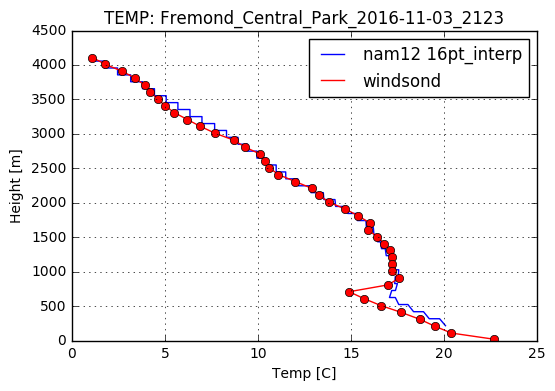

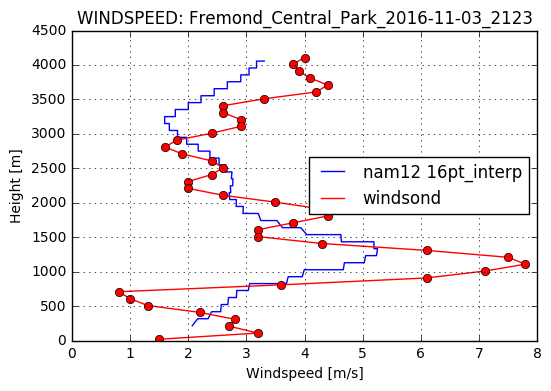

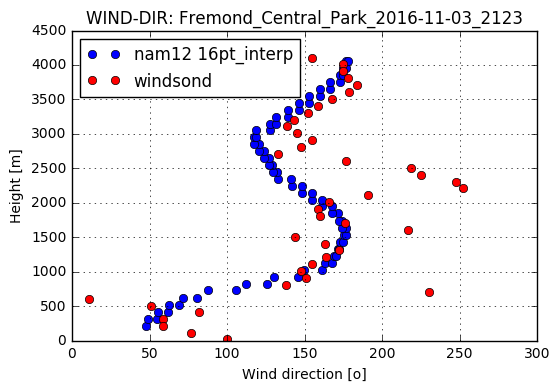

In [13]:
nam12_h_offset = ' 16pt_interp'#is added to the end of the describing legend text of the plot 'Nam12...)
#nam12_h_offset_B = '+21h'


#dp not change
pp = PdfPages(folder + 'Comparison_WS_NAM12(interp16pts)_%s.pdf' %foldername_basic) 
#nam12profiles
df_8pts_profile_A = df_8pts_profile.loc[df_8pts_profile.time_ident == 'Final']
#df_8pts_profile_B = df_8pts_profile.loc[df_8pts_profile.time_ident == 'B']


#dataframe for windsond data
df_ws = pd.read_csv(folder_ws+filename_ws, header = [0,1], delim_whitespace = 1)

#x = temp, y = height
plt.clf()
plt.figure(1)
plt.plot(df_8pts_profile_A.temp,df_8pts_profile_A.alt,'b',label = 'nam12'+nam12_h_offset)
#plt.plot(df_8pts_profile_B.temp,df_8pts_profile_B.alt,'g',label = 'nam12'+nam12_h_offset_B)
plt.plot(df_ws['temp'],df_ws['alt']+ground_height,'r', label = 'windsond')
plt.plot(df_ws['temp'],df_ws['alt']+ground_height,'ro')
plt.ylabel('Height [m]')
plt.xlabel('Temp [C]')
plt.title('TEMP: '+plot_title)
plt.grid(True)
plt.legend(loc='best')
plt.savefig(pp, format='pdf')
#plt.show()



#x = temp, y = windspeed
plt.figure(2)
plt.plot(df_8pts_profile_A.wnd_spd,df_8pts_profile_A.alt,'b',label = 'nam12'+nam12_h_offset)
#plt.plot(df_8pts_profile_B.wnd_spd,df_8pts_profile_B.alt,'g',label = 'nam12'+nam12_h_offset_B)
plt.plot(df_ws['spd'],df_ws['alt']+ground_height,'r', label = 'windsond')
plt.plot(df_ws['spd'],df_ws['alt']+ground_height,'ro')
plt.ylabel('Height [m]')
plt.xlabel('Windspeed [m/s]')
plt.title('WINDSPEED: '+plot_title)
plt.grid(True)
plt.legend(loc=5)
pp.savefig()
#plt.show()



#x = wind-dir, y = height

plt.figure(3)
plt.plot(df_8pts_profile_A.wnd_dir,df_8pts_profile_A.alt,'bo',label = 'nam12'+nam12_h_offset)
#plt.plot(df_8pts_profile_B.wnd_dir,df_8pts_profile_B.alt,'g',label = 'nam12'+nam12_h_offset_B)
plt.plot(df_ws['wind-dir'],df_ws['alt']+ground_height,'ro', label = 'windsond')
#plt.plot(df_ws['wind-dir'],df_ws['alt']+ground_height,'ro')
plt.ylabel('Height [m]')
plt.xlabel('Wind direction [o]')
plt.title('WIND-DIR: '+plot_title)
plt.grid(True)
plt.legend(loc='best')
pp.savefig()

pp.close()            

plt.show()